# **Portfolio selection using Pandas dataframes**

***portfolio_pandas.ipynb***

In this example, we load a dataset with stock information to select a portfolio that maximizes returns subject to a wide range of constraints including sector, risk and ESG restrictions. We showcase the capabilitites of the Xpress Python API regarding the use of Pandas operations to generate aggregate expressions, as well as vector or matrix-based formulations for constraints and the objective function.

&copy; Copyright 2025 Fair Isaac Corporation

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.
 
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This example uses FICO&reg; Xpress software. By running it, you agree to the Community License terms of the [Xpress Shrinkwrap License Agreement](https://www.fico.com/en/shrinkwrap-license-agreement-fico-xpress-optimization-suite-on-premises) with respect to the FICO&reg; Xpress software. See the [licensing options](https://www.fico.com/en/fico-xpress-trial-and-licensing-options) overview for additional details and information about obtaining a paid license.

In [ ]:
# Install the necessary packages
%pip install -q xpress pandas matplotlib seaborn

## Problem description

In this **portfolio optimization** problem, we wish to select stocks to form a portfolio for an asset allocation strategy. A list of stocks is available to be selected and we want to decide the fraction of the available budget to be allocated to each of the selected stocks that maximizes the total expected return.

Stock data comprises an expected return for the coming investment period, an industry sector, an ESG (Environmental, Social, and Governance) score and a coefficient of variation (CV) representing the risk associated with each stock. **The selected portfolio must satisfy the following conditions**:
 - If a particular stock is selected then the total investment on this stock should not be lower than 1% and should not exceed 20% of the available budget.
 - The investment in each of the 8 industry sectors should not exceed 25% of the available budget.
 - At least 10 different stocks must be purchased.
 - The ESG score amongst the selected stocks, weighted by fraction, needs to be at least 70.
 - The weighted average CV score should not exceed 0.5.

The input data file `shares100.csv` provides data, in tabular form, related to 100 stocks with the following fields:
 - *Stock*: Name of the stock.
 - *Return*: The expected return for the investment cycle ahead, per unit of stock.
 - *Sector*: The industry sector the stock belongs to (e.g., Technology, Healthcare, Energy).
 - *ESG score*: The Environmental, Social, and Governance score, which evaluates a company's sustainability and ethical impact.
 - *CV*: the coefficient of variation (CV) representing the volatility (risk) associated with each stock.

The goal is to select the **portfolio that ensures maximum returns while satisfying all constraints**. We further evaluate the impact of setting a range of different thresholds on the maximum average risk and minimum ESG requirements on the optimal return.

## Data preparation, analysis and visualization

We start by importing the essential libraries for optimization (`xpress`), data manipulation (`pandas`, `numpy`), and visualization (`matplotlib`, `seaborn`). 

After defining the value for the constants needed for the mathematical model, we load the dataset included in the file named `shares100.csv` (which must be present in the "data" directory) containing stock information into a Pandas dataframe. Then, we display the first five rows to give a quick overview of the data structure and contents.

In [1]:
import xpress as xp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

MinPerShare = 0.01      # Minimum fraction of capital to invest in a single share
MaxPerShare = 0.2       # Maximum fraction of capital to invest in a single share
MaxPerSector = 0.25     # Maximum fraction of capital to invest in a single sector
MinNumStocks = 10       # Minimum number of stocks in the portfolio
MinESG = 70             # Minimum average ESG score allowed in the portfolio
MaxRisk = 0.5           # Maximum average risk allowed in the portfolio

# Load the shares dataset
shares_df = pd.read_csv("data/shares100.csv")

# Share data overview
print("Data sample for the first 5 rows:")
shares_df.head()

Data sample for the first 5 rows:


,Stock,Return,Sector,ESG score,CV
0,Stock_1,0.1598,Healthcare,73.0,0.5393
1,Stock_2,0.2018,Technology,95.0,0.6427
2,Stock_3,0.0883,Consumer Goods,63.0,0.2355
3,Stock_4,0.2048,Finance,68.0,0.3360
4,Stock_5,0.0818,Finance,65.0,0.4196


The code below creates four subplots with stock distributions using Seaborn and Matplotlib. The subplots in the first row show the distribution of **Returns** and **Sectors**, while the second row displays the distribution of **ESG scores** and **CV scores**. 

Both plots use histograms and contain kernel density estmation curves to further highlight the shape of the data.

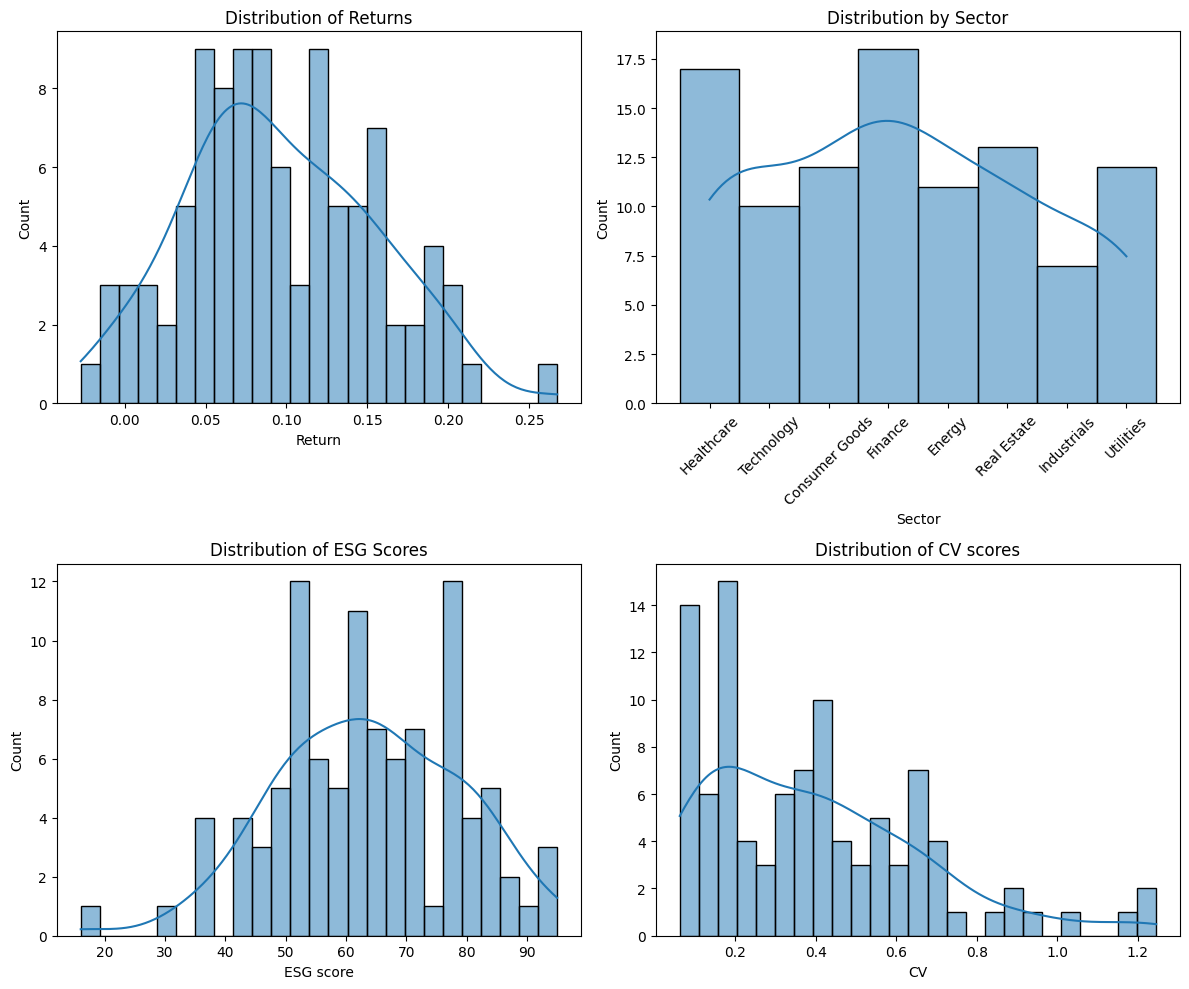

In [2]:
# Plot distributions
plt.figure(figsize=(12, 10))

num_bins = 25

# Plotting the distribution of returns
plt.subplot(2, 2, 1)
sns.histplot(shares_df['Return'], bins=num_bins, kde=True)
plt.title('Distribution of Returns')

# Plotting the distribution of Sector
plt.subplot(2, 2, 2)
plt.xticks(rotation=45)
sns.histplot(shares_df['Sector'], bins=num_bins, kde=True)
plt.title('Distribution by Sector')

# Plotting the distribution of ESG scores
plt.subplot(2, 2, 3)
sns.histplot(shares_df['ESG score'], bins=num_bins, kde=True)
plt.title('Distribution of ESG Scores')

# Plotting the distribution of risk scores
plt.subplot(2, 2, 4)
sns.histplot(shares_df['CV'], bins=num_bins, kde=True)
plt.title('Distribution of CV scores')

plt.tight_layout()
plt.show()

The code cell below plots a **sector-wise analysis** using boxplots, depicting the spread of **returns** and **risk scores** across different sectors. It shows that sectors with higher expected returns are also the most volatile sectors. 

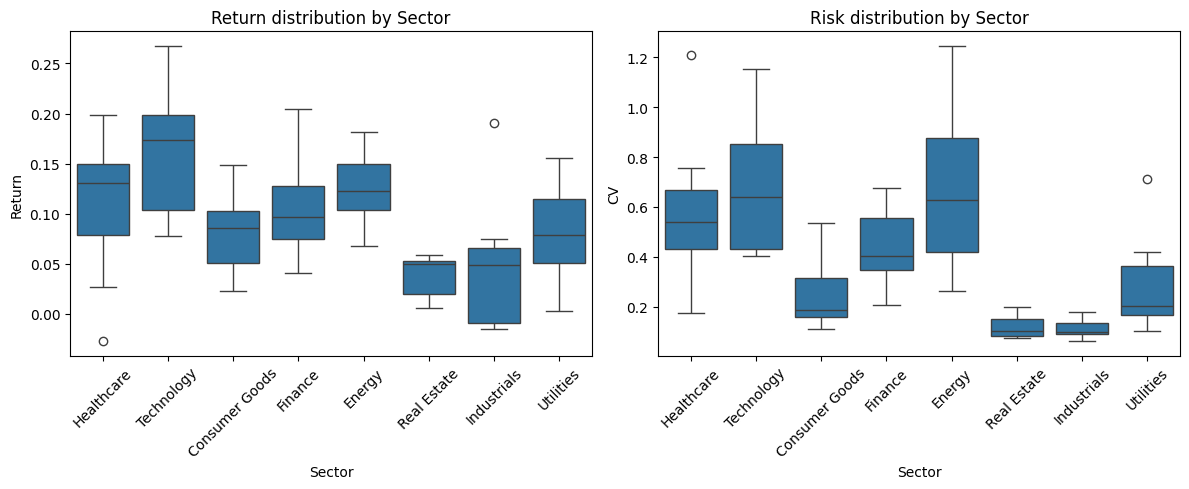

In [3]:
# Set the plot layout
plt.figure(figsize=(12, 5))

# Boxplot for Return by Sector
plt.subplot(1, 2, 1)
sns.boxplot(data=shares_df, x='Sector', y='Return')
plt.xticks(rotation=45)
plt.title('Return distribution by Sector')

# Boxplot for CV score by Sector
plt.subplot(1, 2, 2)
sns.boxplot(data=shares_df, x='Sector', y='CV')
plt.xticks(rotation=45)
plt.title('Risk distribution by Sector')

plt.tight_layout()
plt.show()

## Model implementation and solution printing

We start by defining a set of continuous decision variables $frac_i$ that represent the fraction ($>= 0, <= 1$) of the available budget to be allocated to each stock $i \in \mathcal{S}$, and the auxiliary binary variables $buy_i$ to decide whether stock $i$ is included in the portfolio ($=1$), or not ($=0$).

To take advantage of the **improved Pandas compatibility features introduced in Xpress 9.8**, Pandas series containing Xpress variables or expressions should have the data type set to `xpressobj`, as shown by the code below where the two sets of variables are added to the previously created Xpress problem. 

The NumPy arrays returned by [problem.addVariables](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addVariables.html) are wrapped into Pandas series, which must be added as a new column to the dataframe in order to enable performing the intended Pandas operations.

In [4]:
# Create Xpress problem and variables
p = xp.problem("Portfolio Selection")
shares_df['frac'] = pd.Series(p.addVariables(len(shares_df), vartype=xp.continuous, name='frac'), dtype='xpressobj')
shares_df['buy'] = pd.Series(p.addVariables(len(shares_df), vartype=xp.binary, name='buy'), dtype='xpressobj')


The objective of maximizing the expected returns is defined the sum of the product between the expected return (`RET`) of each stock and the corresponding `frac` variable: $$\max \sum_{i \in \mathcal{S}} RET_i \cdot frac_i$$

As shown in the code cell below, the objective expression can be created using the element-wise product (`*`) of the `Return` and `frac` columns followed by the summation (`sum`) of the resulting series **using Pandas-specific methods**.

The call to [problem.setObjective](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.setObjective.html) then adds the objective function to the problem, specifying that it is to be maximized.


In [5]:
# Objective function: minimize total return
obj = (shares_df['Return'] * shares_df['frac']).sum()
p.setObjective(obj, sense=xp.maximize)

Next we model the following 2 constraints:

- The sum of the portfolio stock allocations should be equal to 1 (fully invested portfolio): 
$$\sum_{i \in \mathcal{S}} frac_i = 1$$

-  Diversification: ensure a minimum number of assets:
$$ \sum_{i \in \mathcal{S}} buy_i \geq \text{MinNumStocks}$$

We simply use the Pandas `sum` operator on the corresponding dataframe column to represent the left-hand side of each constraint. The call to [problem.addConstraint](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addConstraint.html) adds the constraint to the model.


In [6]:
# Spend all the capital
p.addConstraint(shares_df['frac'].sum() == 1)  

# Ensure a minimum total number of assets
p.addConstraint(shares_df['buy'].sum() >= MinNumStocks)

The code below ensures that if a share is selected ($buy$ = 1), then the fraction bought must be at least `MinPerShare` and not exceed `MaxPerShare`. In either case, if the share is not selected ($buy$ = 0), then the fraction must be zero.
 
$$
\text{MinPerShare} \cdot buy_i \leq frac_i \leq \text{MaxPerShare} \cdot buy_i \quad \forall i \in \mathcal{S}
$$

We model those constraints by doing an element-wise product between the corresponding scalar and the `buy` column elements using the multiplication operator (`*`), and equivalently by using the `mul` Pandas method.

In [ ]:
# Linking constraints defining minimum and maximum fraction per share
p.addConstraint(shares_df['frac'] >= MinPerShare * shares_df['buy'])
p.addConstraint(shares_df['frac'] <= shares_df['buy'].mul(MaxPerShare))     # Alternative way of multiplying column x scalar

Just like with the objective function expression, we define the ESG and risk constraints as:

 - Minimum average ESG score constraint:
 $$\sum_{i \in \mathcal{S}} \text{ESG}_i \cdot frac_i \geq \text{MinESG}$$

- Maximum average risk (CV) constraint:
 $$\sum_{i \in \mathcal{S}} \text{CV}_i \cdot frac_i \leq \text{MaxRisk}$$

These constraints can be modeled by using the element-wise product of the corresponding column and the `frac` column, followed by the summation of the resulting series using the `sum` method to build the left-hand side of the constraint.

In [ ]:
# Average ESG score constraint: the weighted average ESG score must be at least MinAvgESG
avg_esg = (shares_df['ESG score'] * shares_df['frac']).sum() >= MinESG

# Risk constraint: average risk (CV) must be less than or equal to MaxRisk
avg_risk = (shares_df['CV'] * shares_df['frac']).sum() <= MaxRisk

p.addConstraint(avg_esg, avg_risk)

The constraint that ensures that the total fraction of shares bought in any given sector does not exceed `MaxPerSector`:
 $$\sum_{i \in \mathcal{S}: Sector[i] = n} frac_i \leq \text{MaxPerSector}, \forall n \in SECTORS$$

This constraint can be easily modeled using Pandas by applying the `groupby()` method to group shares by their sector (e.g., Technology, Healthcare, etc.), and then calling the `sum` function to sum the variables representing fractional purchases (`frac`) within each sector. This expression produces a series of constraints, one for each sector, which are then added to the problem by a single call to `addConstraint`.

**Note**: the `groupby()` method for constraint creation is only compatible with Pandas versions < 3.0.

In [9]:
# Maximum per sector: total fraction invested in each sector does not exceed MaxPerSector
p.addConstraint(shares_df.groupby('Sector')['frac'].sum() <= MaxPerSector)

Lastly, we turn off the solver logs by using the [outputlog](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/HTML/OUTPUTLOG.html) control, and then solve the problem by calling [problem.optimize](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.optimize.html) which returns a solve status (completed, stopped, ...) and solution status (optimal, infeasible, ...). 

In case a (feasible or optimal) solution has been found, we display the computed metrics and plot the final solution (i.e. the portfolio composition) using a donut plot with selected stocks in descending order of fraction value.

Expected return       0.204827
Average risk (CV)     0.500000
Average ESG          71.185023
# selected stocks    10.000000
Largest position      0.200000
Smallest position     0.010000
MaxPerSector          0.250000
dtype: float64


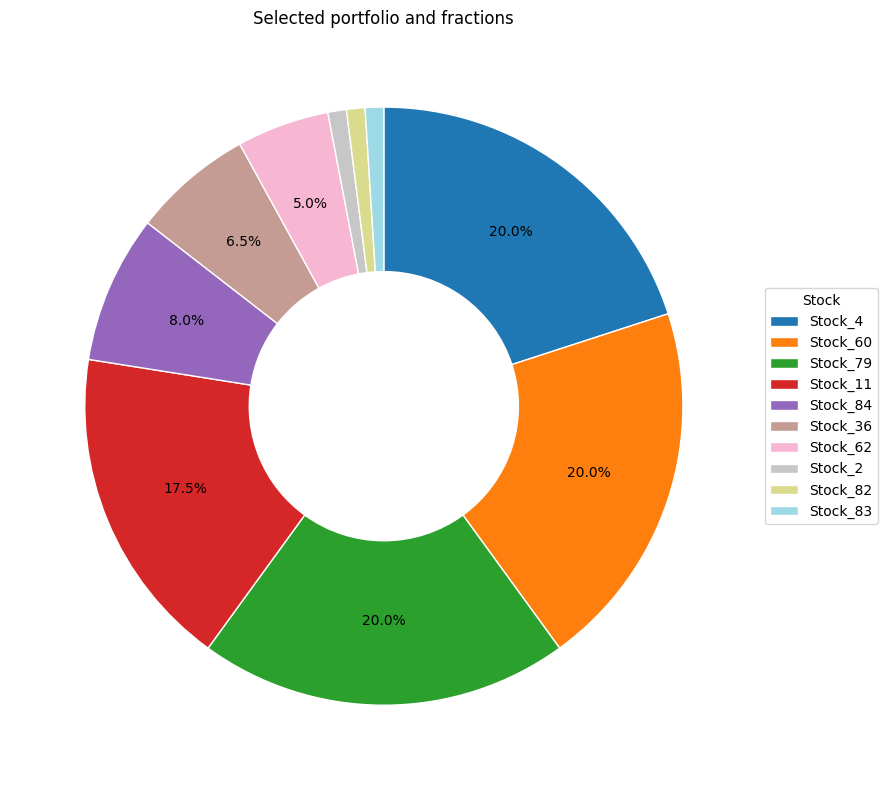

In [ ]:
p.controls.outputlog = 0        # Suppress output log

# Solve optimization problem
solvestatus, solstatus = p.optimize()

if solstatus in (xp.SolStatus.OPTIMAL,xp.SolStatus.FEASIBLE):
    # Get solution
    shares_df["fraction"] = p.getSolution(shares_df['frac'])

    # Compute metrics
    SummaryValues = pd.Series({
        "Expected return": p.attributes.objval,
        "Average risk (CV)": (shares_df["CV"] * shares_df["fraction"]).sum(),
        "Average ESG": (shares_df["ESG score"] * shares_df["fraction"]).sum(),
        "# selected stocks": (shares_df["fraction"] > 0).sum(),
        "Largest position": (shares_df["fraction"]).max(),
        "Smallest position": shares_df[shares_df["fraction"] > 0]["fraction"].min(),
        "MaxPerSector": shares_df.groupby('Sector')['fraction'].sum().max(),
    })
    print(SummaryValues)
    
    # Plot portfolio composition
    filtered_df = shares_df[shares_df["fraction"] >= 0.005] # Filter rows where fraction is greater than or equal to 0.005
    plot_df = filtered_df.sort_values('fraction', ascending=False) # Sort so the largest slices are first

    sizes = plot_df['fraction'].astype(float).values        # The wedge sizes
    labels = plot_df['Stock'].astype(str).values            # The labels for each wedge

    colors = plt.cm.tab20(np.linspace(0, 1, len(sizes)))    # Color palette
    threshold_pct = 3.0                                     # Only show % on wedges >= this threshold

    fig, ax = plt.subplots(figsize=(9, 8))
    wedges, _, autotexts = ax.pie(
        sizes,
        colors=colors,
        startangle=90,
        counterclock=False,
        autopct=lambda p: f'{p:.1f}%' if p >= threshold_pct else '',
        pctdistance=0.72,
        wedgeprops=dict(width=0.55, edgecolor='white'),     # Donut style (more readable)
        textprops=dict(color='black', fontsize=10)
    )

    ax.legend(
        wedges, labels,
        title='Stock',
        loc='center left',
        bbox_to_anchor=(1.0, 0.5)
    )

    ax.set_title('Selected portfolio and fractions')
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()
else:
    print("Optimization did not find a solution.")
    print("Status:", p.attributes.solvestatus)

## Experiments and visualization of tradeoff curves

In this section, we wrap the full mathematical model into an `optimize_portfolio` function that receives the input dataframe and the ` MaxRisk` and `MinESG` parameters as arguments such that the model can easily be run for a range of values in order to study their impact on the portfolio composition

This function is then invoked for the base case scenario, achieving the same solution shown previously.

In [ ]:
# This function optimizes the portfolio based on the provided DataFrame and parameters
def optimize_portfolio(df, MaxRisk=1, MinESG=0):
    """
    Optimize the portfolio based on the given DataFrame and MaxRisk / MinESG parameters

    Inputs:
    df:             DataFrame containing stock data with risk returns, sectors, ESG scores, and CV metrics
    MinAvgESG:      Minimum average ESG score for the portfolio
    MaxRisk:        Maximum risk (CV) allowed for the portfolio

    Outputs:
    SummaryValues:  Series containing key metrics of the optimized portfolio
    """
    
    # Create Xpress problem and variables
    p = xp.problem("Portfolio Selection")
    df['frac'] = pd.Series(p.addVariables(len(df), vartype=xp.continuous, name='frac'), dtype='xpressobj')
    df['buy'] = pd.Series(p.addVariables(len(df), vartype=xp.binary, name='buy'), dtype='xpressobj')

    # Objective function: total return
    obj = xp.Sum(df['Return'] * df['frac'])
    p.setObjective(obj, sense=xp.maximize)

    # Spend all the capital
    p.addConstraint(df['frac'].sum() == 1)  

    # Ensure a minimum total number of assets.
    p.addConstraint(df['buy'].sum() >= MinNumStocks)

    # Linking constraints defining minimum and maximum fraction per share
    p.addConstraint(df['frac'] >= MinPerShare * df['buy'])
    p.addConstraint(df['frac'] <= df['buy'].mul(MaxPerShare)) # alternative way of multiplying column x scalar

    # Risk constraint: average risk (CV) must be less than or equal to MaxRisk
    avg_risk = (df['CV'] * df['frac']).sum() <= MaxRisk
    p.addConstraint(avg_risk)

    # Average ESG score constraint: the weighted average ESG score must be at least MinAvgESG
    avg_esg = (df['ESG score'] * df['frac']).sum() >= MinESG
    p.addConstraint(avg_esg)

    # Maximum per sector: total fraction invested in each sector does not exceed MaxPerSector
    p.addConstraint(df.groupby('Sector')['frac'].sum() <= MaxPerSector)
    
    p.controls.outputlog = 0  # Suppress output log

    # Solve optimization problem
    solvestatus, solstatus = p.optimize()

    if solstatus in (xp.SolStatus.OPTIMAL,xp.SolStatus.FEASIBLE):
        # Get solution as a list from the output dict
        df["fraction"] = list(p.getSolution(df['frac']))

        # Compute metrics
        SummaryValues = pd.Series({
            "Expected return": (df["Return"] * df["fraction"]).sum(),
            "Average risk (CV)": (df["CV"] * df["fraction"]).sum(),
            "Average ESG": (df["ESG score"] * df["fraction"]).sum(),
            "# selected stocks": (df["fraction"] > 0).sum(),
            "Largest position": (df["fraction"]).max(),
            "Smallest position": df[df["fraction"] > 0]["fraction"].min(),
            "MaxPerSector": df.groupby('Sector')['fraction'].sum().max(),
        })

        return SummaryValues
    else:
        print("Optimization did not find a solution.")
        print("Status:", p.attributes.solvestatus)
        return None
    
# Test the model with the base case parameters
print(optimize_portfolio(shares_df, MinESG=70, MaxRisk=0.5))


Expected return       0.204827
Average risk (CV)     0.500000
Average ESG          71.185023
# selected stocks    10.000000
Largest position      0.200000
Smallest position     0.010000
MaxPerSector          0.250000
dtype: float64


#### Risk tolerance analysis

Now we define a range of 14 possible values for the `MaxRisk` (maximum average CV) parameter, ranging between 0.1 and 0.75 in steps of 0.05.

Next, we run the optimization model for each step, saving each series as a new row in a dataframe.

In [12]:
# Define range for max risk values
maxrisk_rng = np.arange(0.1, 0.8, 0.05) # Define input values for the optimization

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame() 

# Run the function for each value and collect the results
for v in maxrisk_rng:
    metrics = optimize_portfolio(shares_df, MaxRisk=v, MinESG=50) # Get metrics for the current MaxRisk value
    metrics['Max. Risk'] = v
    results_df = pd.concat([results_df, metrics.to_frame().T], ignore_index=True)

The following defines a function to do a **line plot of the efficient frontier** measuring returns (*y*-axis) against a given metric (*x*-axis).

It is followed by a call to the function for plotting the efficient frontier of `Return` vs `Risk` using the previous results:

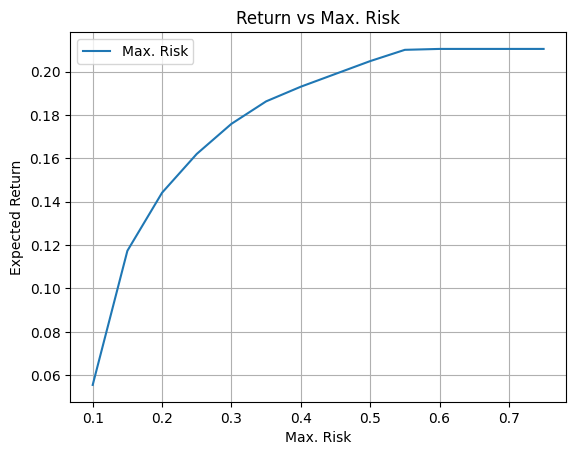

In [13]:
# Plot the metrics
def line_plot(df, metric):
    plt.plot(df[metric], df['Expected return'], label=metric)

    plt.title('Return vs {}'.format(metric))
    plt.xlabel(metric)
    plt.ylabel('Expected Return')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the metrics
line_plot(results_df, 'Max. Risk')

#### ESG score analysis

Finally we define a range (65 to 89, in unit steps) of possible values for the `MinESG` parameter, re-solve the problem and plot the impact on the `Return` using the previous function:

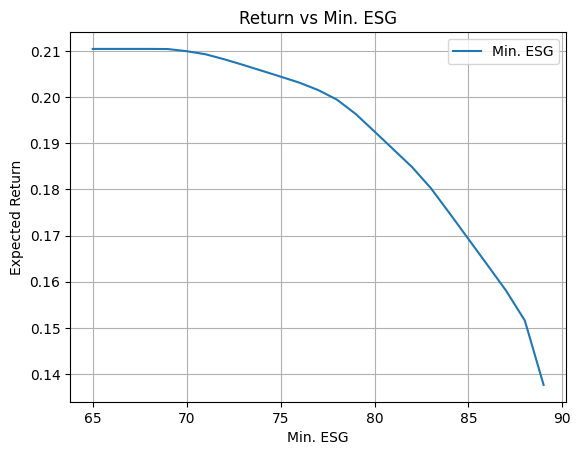

In [14]:
# Define range for max risk values
esg_values = np.arange(65, 90, 1) # Define input values for the optimization

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame() 

# Run the function for each value and collect the results
for v in esg_values:
    metrics = optimize_portfolio(shares_df, MinESG=v) # Get metrics for the current MaxRisk value
    metrics['Min. ESG'] = v
    results_df = pd.concat([results_df, metrics.to_frame().T], ignore_index=True)

# Plot the metrics
line_plot(results_df, 'Min. ESG')